In [7]:
import torch
import torch.nn as nn
import timm
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define Albumentations-based augmentation pipeline
augmentation = A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [11]:
from torch.utils.data import random_split

# Load dataset
dataset = datasets.ImageFolder(
    root="/kaggle/input/ewastedata3/Dataset",
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

# Get class names and their indices
class_names = dataset.classes
print("Class Names:", class_names)

# Define the target classes for augmentation
target_classes = ["mix", "laptop", "keyboard", "monitor"]
target_indices = [class_names.index(cls) for cls in target_classes]

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Class Names: ['keyboard', 'laptop', 'mix', 'mobile', 'monitor', 'mouse']


In [12]:
# Define augmented dataset class
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, original_dataset, target_indices, num_augmented_per_class=10):
        self.dataset = dataset
        self.original_dataset = original_dataset  # Full dataset (ImageFolder)
        self.target_indices = target_indices  # Only augment these classes
        self.num_augmented_per_class = num_augmented_per_class

        # Collect all indices of images belonging to target classes
        self.target_class_samples = {idx: [] for idx in target_indices}
        for i, (_, label) in enumerate(original_dataset.samples):
            if label in target_indices:
                self.target_class_samples[label].append(i)

    def __len__(self):
        # Original dataset size + augmented samples for target classes
        return len(self.dataset) + self.num_augmented_per_class * len(self.target_indices)

    def __getitem__(self, idx):
        if idx < len(self.dataset):
            image, label = self.dataset[idx]
            return image, label

        # Augment images from "mix" and "laptop" classes
        class_idx = self.target_indices[(idx - len(self.dataset)) // self.num_augmented_per_class]
        original_idx = np.random.choice(self.target_class_samples[class_idx])

        image, label = self.original_dataset[original_idx]
        image = np.array(image.permute(1, 2, 0) * 255, dtype=np.uint8)  # Convert tensor to numpy
        augmented = augmentation(image=image)["image"]  # Apply augmentation
        return augmented, label

# Apply augmentation only to "mix" and "laptop" classes
augmented_train_dataset = AugmentedDataset(train_dataset, dataset, target_indices, num_augmented_per_class=3)

In [13]:
dataset.classes, len(dataset.classes)

(['keyboard', 'laptop', 'mix', 'mobile', 'monitor', 'mouse'], 6)

In [23]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
     
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
    

In [15]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    return correct / total

In [102]:
def evaluate_model_test(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            _, predicted = torch.max(probs, 1)  # Get class indices
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(probs.cpu().numpy())  # Store probability distributions
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))  # Convert probs to class indices
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, np.argmax(all_preds, axis=1), target_names=class_names))
    
    # AUC-ROC Curve
    if num_classes > 1:
        roc_score = roc_auc_score(all_labels, all_preds, multi_class='ovr')
        print(f"AUC-ROC Score: {roc_score:.4f}")

        # Plot ROC curve
        plt.figure(figsize=(4, 3))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_preds)[:, i])
            plt.plot(fpr, tpr, label=f'Class {class_names[i]}')
        
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC-ROC Curve")
        plt.legend()
        plt.show()

    return correct / total

In [17]:
# Create data loaders
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes after augmentation
print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Augmented Train Dataset Size: {len(augmented_train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Original Train Dataset Size: 354
Augmented Train Dataset Size: 366
Test Dataset Size: 89


In [121]:
# Load ViT model
num_classes = len(dataset.classes)
model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-6) 

# Train the model 
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.8812, Train Acc: 0.6858
Epoch 2/5, Loss: 0.0980, Train Acc: 0.9645
Epoch 3/5, Loss: 0.0385, Train Acc: 0.9863
Epoch 4/5, Loss: 0.0135, Train Acc: 0.9945
Epoch 5/5, Loss: 0.0166, Train Acc: 0.9918


In [122]:
test_acc = evaluate_model(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9464, Recall: 0.9438, F1-score: 0.9448
Test Accuracy: 0.9438


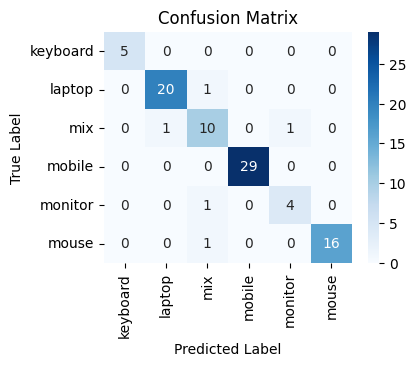

Classification Report:
              precision    recall  f1-score   support

    keyboard       1.00      1.00      1.00         5
      laptop       0.95      0.95      0.95        21
         mix       0.77      0.83      0.80        12
      mobile       1.00      1.00      1.00        29
     monitor       0.80      0.80      0.80         5
       mouse       1.00      0.94      0.97        17

    accuracy                           0.94        89
   macro avg       0.92      0.92      0.92        89
weighted avg       0.95      0.94      0.94        89

AUC-ROC Score: 0.9934


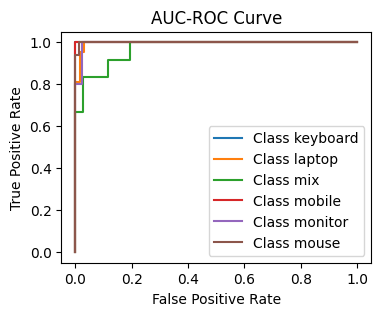

Test Accuracy: 0.9438


In [123]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## VGG 16

In [54]:
import torchvision.models as models

num_classes = len(dataset.classes)

# Load VGG16 model
# model = models.vgg16(pretrained=True)
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Modify classifier for the new number of classes
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=5e-4) #2, 5, 4, 6

In [55]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 1.4595, Train Acc: 0.4372
Epoch 2/5, Loss: 0.6429, Train Acc: 0.7678
Epoch 3/5, Loss: 0.3079, Train Acc: 0.8962
Epoch 4/5, Loss: 0.1567, Train Acc: 0.9508
Epoch 5/5, Loss: 0.0735, Train Acc: 0.9754


In [56]:
test_acc = evaluate_model(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9347, Recall: 0.9326, F1-score: 0.9316
Test Accuracy: 0.9326


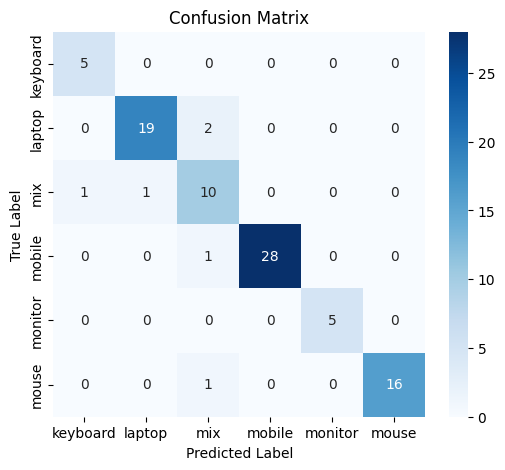

Classification Report:
              precision    recall  f1-score   support

    keyboard       0.83      1.00      0.91         5
      laptop       0.95      0.90      0.93        21
         mix       0.71      0.83      0.77        12
      mobile       1.00      0.97      0.98        29
     monitor       1.00      1.00      1.00         5
       mouse       1.00      0.94      0.97        17

    accuracy                           0.93        89
   macro avg       0.92      0.94      0.93        89
weighted avg       0.94      0.93      0.94        89

AUC-ROC Score: 0.9942


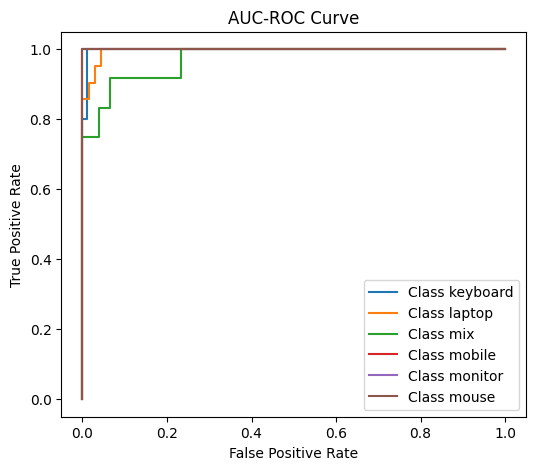

Test Accuracy: 0.9326


In [34]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## ReNet-50

In [98]:
# Load ResNet-50 model
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)

In [99]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=8)

Epoch 1/8, Loss: 1.6238, Train Acc: 0.3525
Epoch 2/8, Loss: 1.2394, Train Acc: 0.4836
Epoch 3/8, Loss: 0.8633, Train Acc: 0.6694
Epoch 4/8, Loss: 0.4949, Train Acc: 0.8880
Epoch 5/8, Loss: 0.2867, Train Acc: 0.9262
Epoch 6/8, Loss: 0.1881, Train Acc: 0.9481
Epoch 7/8, Loss: 0.1264, Train Acc: 0.9809
Epoch 8/8, Loss: 0.0528, Train Acc: 1.0000


In [100]:
test_acc = evaluate_model(model, test_loader) #38
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9178, Recall: 0.9101, F1-score: 0.9117
Test Accuracy: 0.9101


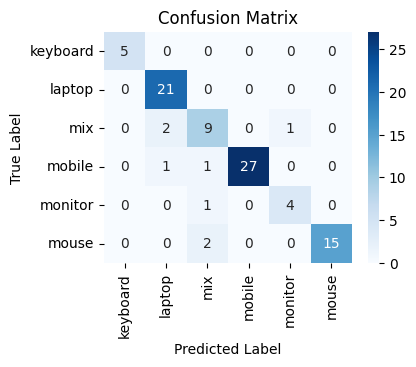

Classification Report:
              precision    recall  f1-score   support

    keyboard       1.00      1.00      1.00         5
      laptop       0.88      1.00      0.93        21
         mix       0.69      0.75      0.72        12
      mobile       1.00      0.93      0.96        29
     monitor       0.80      0.80      0.80         5
       mouse       1.00      0.88      0.94        17

    accuracy                           0.91        89
   macro avg       0.89      0.89      0.89        89
weighted avg       0.92      0.91      0.91        89

AUC-ROC Score: 0.9785


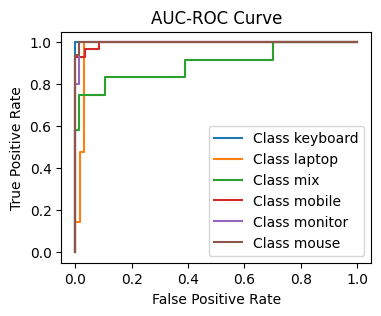

Test Accuracy: 0.9101


In [103]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

## Xception-Net

In [88]:
model = timm.create_model("xception", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()   # 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [89]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 1.1593, Train Acc: 0.6967
Epoch 2/5, Loss: 0.3533, Train Acc: 0.9426
Epoch 3/5, Loss: 0.1645, Train Acc: 0.9699
Epoch 4/5, Loss: 0.0633, Train Acc: 0.9918
Epoch 5/5, Loss: 0.0619, Train Acc: 0.9918


In [79]:
test_acc = evaluate_model(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9280, Recall: 0.9101, F1-score: 0.9146
Test Accuracy: 0.9101


In [90]:
test_acc = evaluate_model(model, test_loader) 
print(f"Test Accuracy: {test_acc:.4f}") 

Precision: 0.9368, Recall: 0.9326, F1-score: 0.9329
Test Accuracy: 0.9326


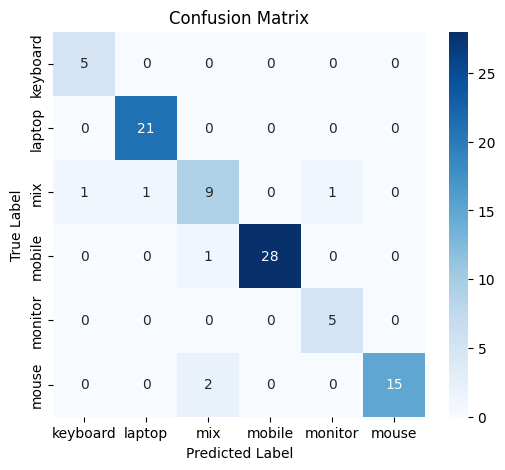

Classification Report:
              precision    recall  f1-score   support

    keyboard       0.83      1.00      0.91         5
      laptop       0.95      1.00      0.98        21
         mix       0.75      0.75      0.75        12
      mobile       1.00      0.97      0.98        29
     monitor       0.83      1.00      0.91         5
       mouse       1.00      0.88      0.94        17

    accuracy                           0.93        89
   macro avg       0.90      0.93      0.91        89
weighted avg       0.94      0.93      0.93        89

AUC-ROC Score: 0.9697


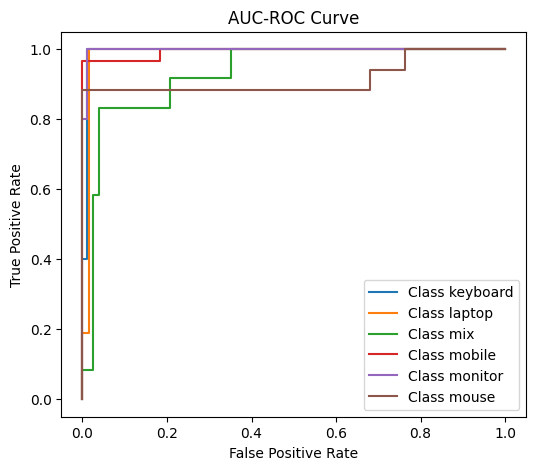

Test Accuracy: 0.9326


In [91]:
test_acc = evaluate_model_test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}") 

### Hybrid approach